In [63]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”
── Conflicts ────

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


#### Introduction   
1. Clearly state the question you will try to answer with your project   

We are trying to analyze the probability of an individual having a heart attack using the attribute (nums: from 0 to 4) using 6 predictors as described in the following paragraph. 

2. Identify and describe the dataset that will be used to answer the question   

We are using the “processed.cleveland.data”. This dataset does not need to be cleaned since it does not have any missing data or missing attributes. In order to make up a tidy format, we only added column names. We have splitted 75% of the data to be the training data, and with the rest of 25% as the testing data. We created graphs based on the training data. 


In [74]:
heart_disease_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"


heart_disease_data <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                        mutate(cp = as.factor(cp), fbs = as.factor(fbs), restecg = as.factor(restecg), 
                               exang = as.factor(exang), slope = as.factor(slope), sex = as.factor(sex)) %>% 
                        select(age, sex, cp, chol, fbs, slope, num)

heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

head(heart_disease_data, 10)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,chol,fbs,slope,num
<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
63,1,1,233,1,3,0
67,1,4,286,0,2,2
67,1,4,229,0,2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,354,0,1,0
63,1,4,254,0,2,2
53,1,4,203,1,3,1


* Age: age in years
* Sex: ( 1 = male, 0 = female)
* Cp: chest pain type
Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4 asymptomatic
* Trestbps: Resting Blood pressure ( in mm Hg on admission to hospital)
* Chol: Serum cholesterol in mg/dl
* Fbs: Fastig blood suger > 120 (1 = true, 0 = false)
* Dm: 1 = history if diabetes , 0 = no such history)
* Restecg: Resting electro cardiac results
Value 0 : normal
Value 1: having ST-T wave abnormality ( T wave inversion and/or ST elevation or depression of > 0.05 mV)
Value 2” Showing probable or definite left ventricular hypertrophy by Estes’ criteria
* Thalach: maximum heart rate achieved
* Exang: exercise induced angina (1 = yes ,0 = no)
* Oldpeak:ST depression induced by exercise relative to rest
* Slope: The slope of the peak exercise ST segment
Value 1: upsloping
Value 2: flat
Value 3: downsloping
* Ca: Number of major vessels (0-3) coloured by fluorosopy
* Thal: 3 = normal , 6= fixed defect , 7 = reversible defect
* Num: diagnosis of heart disease
Value 0 <50% diameter narrowing
Value 1 > 50% Diameter narrowing



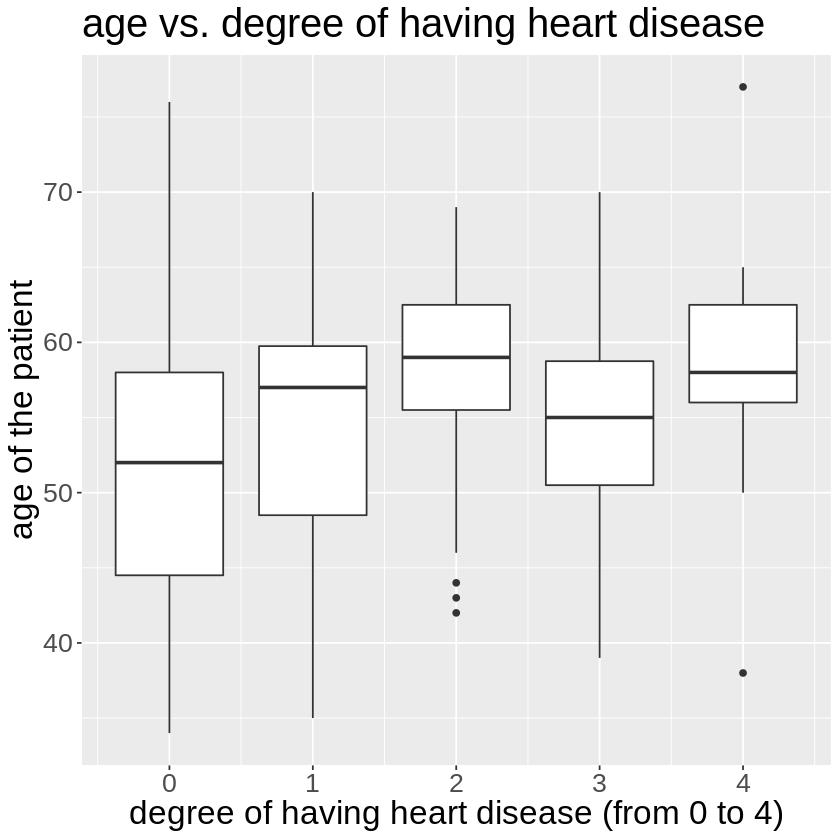

In [75]:
age_vs_heart_disease <- heart_disease_train %>% 
                    ggplot(aes(x = num, y = age)) +
                    geom_boxplot(aes(group = num)) +
                    labs(x = "degree of having heart disease (from 0 to 4)", y = "age of the patient",
                        color = "sex") +
                    ggtitle("age vs. degree of having heart disease") +
                    theme(text = element_text(size = 20))
                    
age_vs_heart_disease

`summarise()` regrouping output by 'num' (override with `.groups` argument)



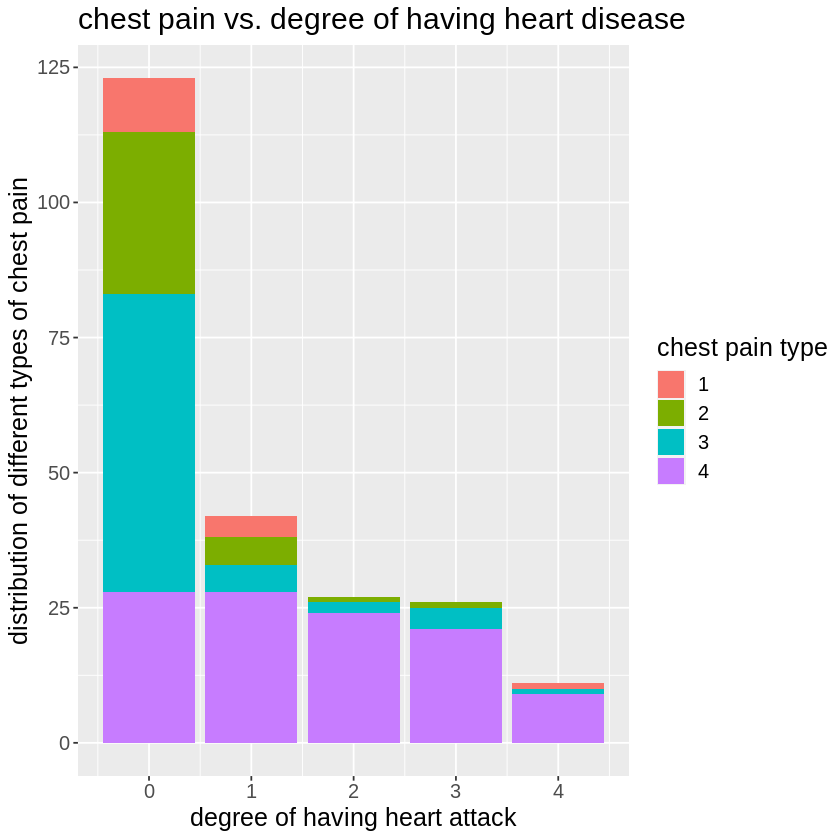

In [76]:
sex_vs_heart_disease <- heart_disease_train %>% 
                        select(num, cp) %>% 
                        group_by(num, cp) %>% 
                        summarize(n = n()) %>% 
                        ggplot(aes(x = num, y = n, fill = cp)) +
                        geom_bar(stat = "identity") +
                        labs(x = "degree of having heart attack", y = "distribution of different types of chest pain", fill = "chest pain type") +
                        ggtitle("chest pain vs. degree of having heart disease") +
                        theme(text = element_text(size = 15))
sex_vs_heart_disease

#### Method

In the proposal, regarding the data analysis, in order to show the distribution of patient ages for each heart disease class, a boxplot of age and degree of heart disease as factors was first created to try to find the effect of these.  Then we also made a barplot of the type of chest pain against heart disease. The graph shows the distribution of different chest pain types in different heart disease classes.     
In order to make the prediction, there are three steps to do:
1. Create a k-nn model specification and a recipe of the fit method.
2. Train the model with the training data to build the classifier.
3. Plug in the test data and make the predictions; use the classifier to prejudice the labels in the test sets.          

We predict that gender, fasting blood sugar(fbs) and cholesterol levels(chol) are more important than other variables compared to age and chest pain type(cp), because based on the initial study, there is not a huge difference between age and chest pain of types 1, 2, and 3 (since type 4 chest pain occur among all level of patients). Therefore, in the following study, we will focus on finding a deeper relationship between these factors and heart disease class. Scatter plots will be used to visualize the predictions.


#### Expected Outcomes and Significance    

1. What do you expect to find?   

Our training dataset with six predictors will allow us to predict the probability of an individual contracting heart disease with the six predictors data.   
Additionally, we hope to discover which factors are most associated with a person's risk of developing a heart disease.  

2. What impact could such findings have?    

With this finding, doctors would be able to analyze patients’ records in a more informative manner. It will be easier to make a swift decision to conduct further diagnostic cardiology on the patient if a certain index is abnormal as indicated in the report later, and this will significantly reduce the chance of misdiagnosis and provide more time for patient diagnosis and treatment.  

3. What future questions could this lead to?   

As this dataset only has 303 instances which is not sufficient for making accurate predictions, we could increase the accuracy of prediction by including more instances . Furthermore, since this data set only contains patients’ data in Cleveland, it would also be interesting to observe if the key factors leading to heart disease differ between different locations if we have a heart disease data set from a collection of locations. 
